# Alogirtmos Random Forest

## Objetivos
* Analizar las distintas opciones de scikit-learn a la hora de crear algoritmos del tipo Random Forest

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, scikit-learn

Software versions
Python 3.5.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.9.16 gentoo x86_64 with debian stretch sid
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.0
pandas 0.19.2
scikit-learn 0.18.1
Mon Apr 10 14:55:34 2017 UTC

In [30]:
import os
import sys
sys.path.append("../src/")

from collections import Counter
import pandas as pd
import matplotlib
import numpy as np
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import ml_plots as mp
from scoring_functions import my_accuracy_scorer
from scoring_functions import my_brier_scorer

pd.options.display.float_format = '{:,.3f}'.format
matplotlib.rcParams.update({'font.size': 12})

In [71]:
SCORES = [(my_accuracy_scorer, 0.5, 1.01), (my_brier_scorer, -0.5, 0.01)]
IN_OPTIONS = ['IN_CR', 'IN_CS', 'IN_DS', 'is_Table', 'is_Columnar', 'is_Int', 'is_Float', 'is_String', 'Type_Size', 'Chunk_Size',
              'Mean', 'Median', 'Sd', 'Skew', 'Kurt', 'Min', 'Max', 'Q1', 'Q3', 'BLZ_CRate', 'BLZ_CSpeed', 'BLZ_DSpeed', 'LZ4_CRate',
              'LZ4_CSpeed', 'LZ4_DSpeed']
OUT_CODEC = ['Blosclz', 'Lz4', 'Lz4hc', 'Snappy', 'Zstd']
OUT_FILTER = ['Noshuffle', 'Shuffle', 'Bitshuffle'] 
OUT_LEVELS = ['CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8', 'CL9']
OUT_BLOCKS = ['Block_8', 'Block_16', 'Block_32', 'Block_64', 'Block_128', 'Block_256', 'Block_512', 'Block_1024', 'Block_2048']
OUT_OPTIONS = OUT_CODEC + OUT_FILTER + OUT_LEVELS + OUT_BLOCKS

In [72]:
df = pd.read_csv('../data/training_data.csv', sep='\t')
X, Y = df[IN_OPTIONS].values, df[OUT_OPTIONS].values

In [6]:
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1)

## LEARNING CURVES

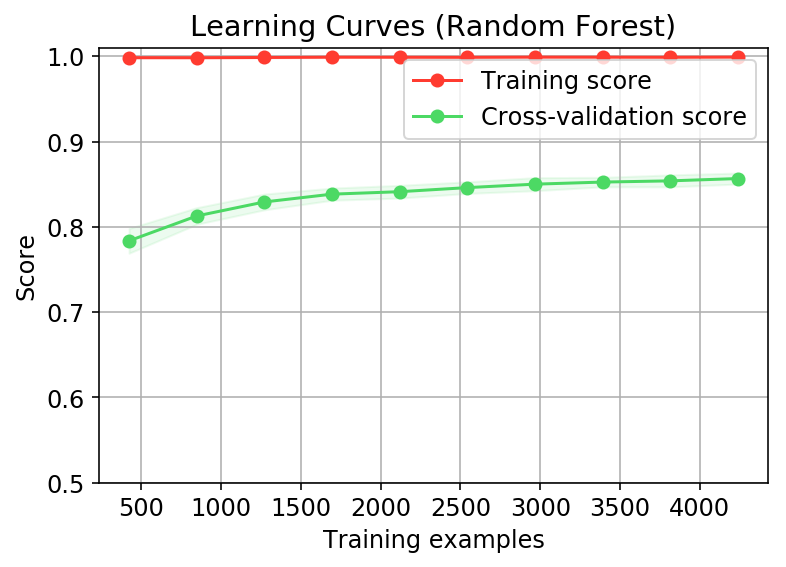

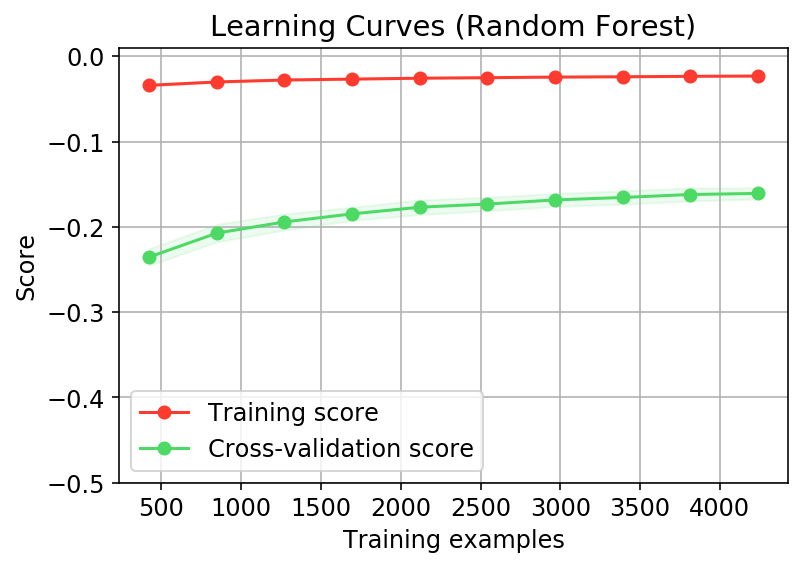

In [20]:
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.1)
for score in SCORES:
    mp.plot_learning_curve(rfc, title, X, Y, scoring=score[0], ylim=(score[1], score[2]), cv=cv, n_jobs=-1,
                       train_sizes=np.linspace(.1, 1.0, 10))

## VALIDATIONS CURVES

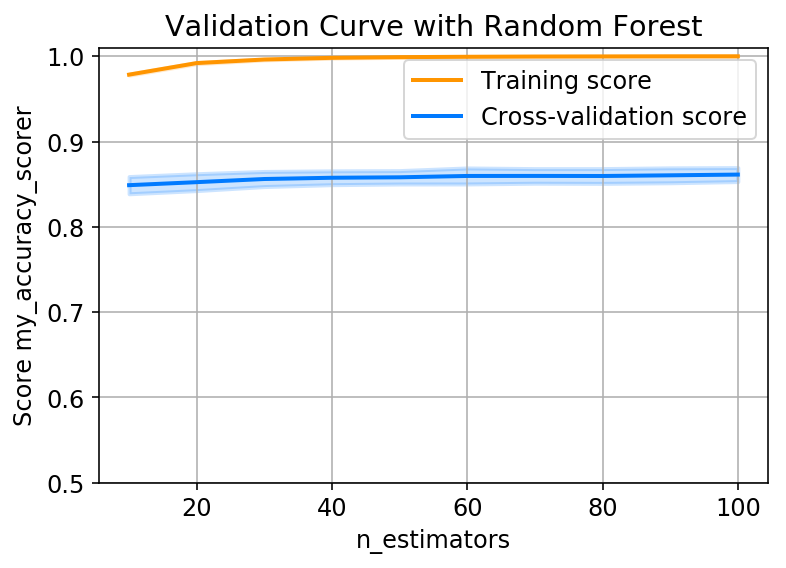

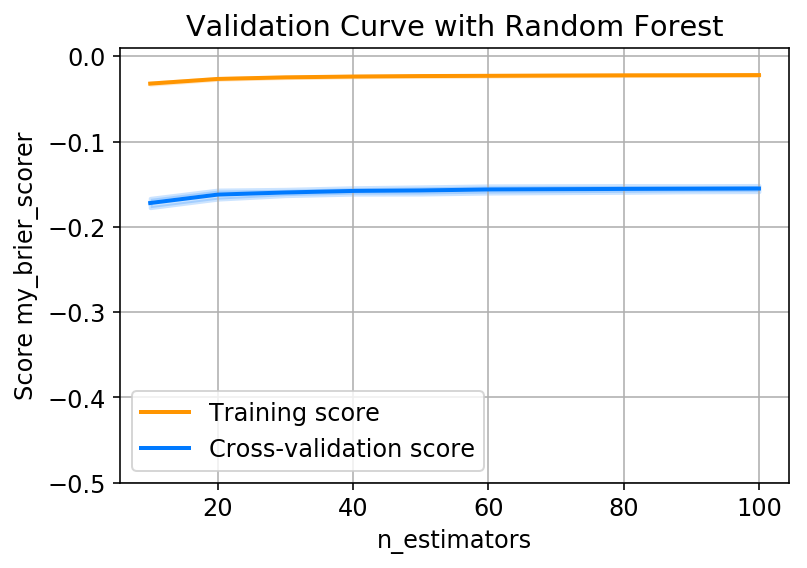

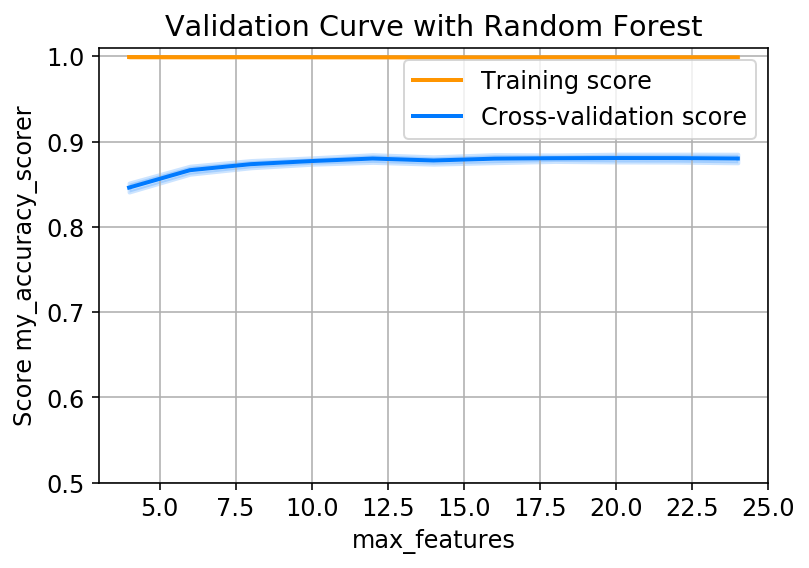

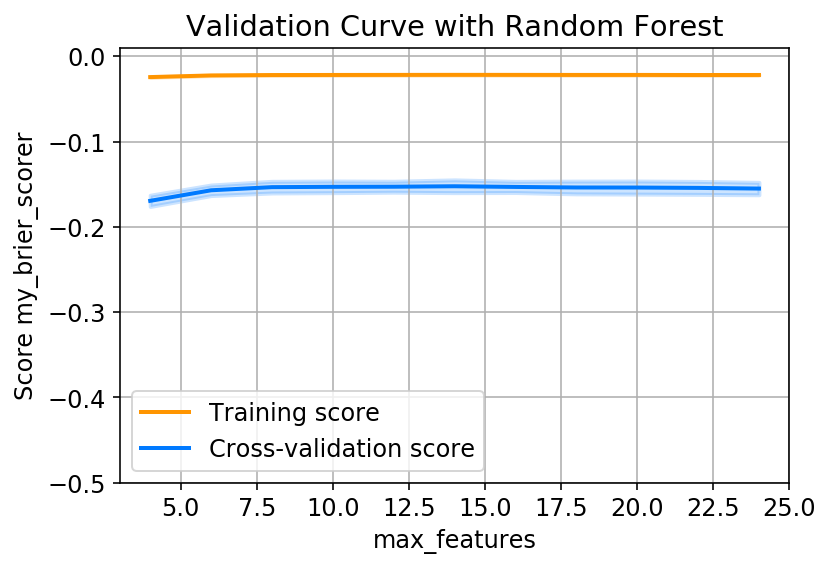

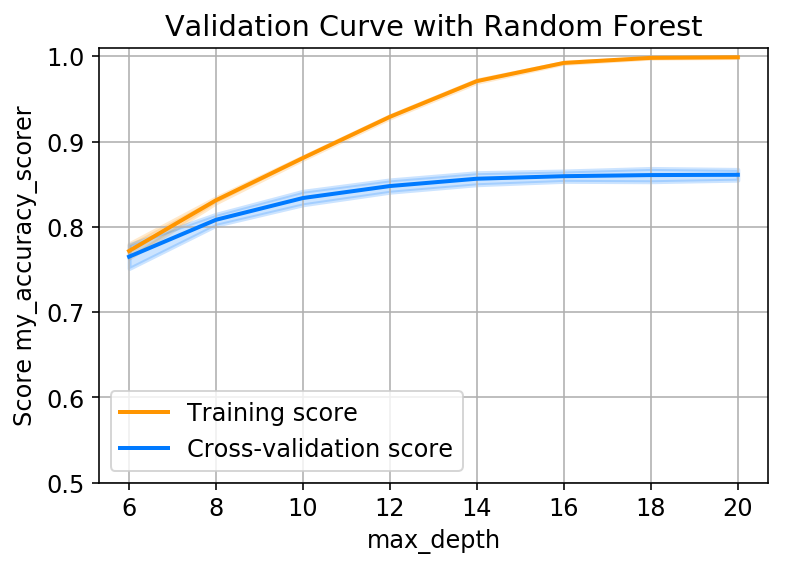

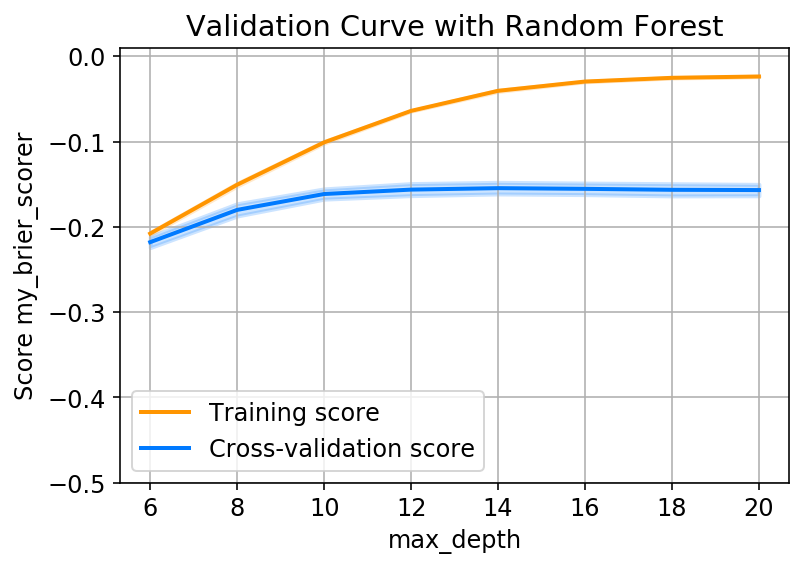

In [25]:
PARAM_NAMES = ['n_estimators', 'max_features', 'max_depth']
PARAM_RANGES = [[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
                [6, 8, 10, 12, 14, 16, 18, 20]]
for i in range(3):
    for score in SCORES:
        mp.plot_validation_curve(rfc, X, Y, param_name=PARAM_NAMES[i], param_range=PARAM_RANGES[i],
                              cv=cv, scoring=score[0], ylim=(score[1], score[2]))

## NESTED CV

In [7]:
nested_clf = joblib.load('../src/nested_estimators_my_accuracy_scorer.pkl')
non_nested_clf = joblib.load('../src/non_nested_estimators_my_accuracy_scorer.pkl')

In [15]:
crits = []
boots = []
weights = []
for est in non_nested_clf:
    aux_dict = est.get_params()
    crits.append(aux_dict.get('criterion'))
    boots.append(aux_dict.get('bootstrap'))
    weights.append(aux_dict.get('class_weight'))
print(Counter(crits))
print(Counter(boots))
print(Counter(weights))

Counter({'entropy': 27, 'gini': 3})
Counter({False: 30})
Counter({None: 30})


In [16]:
crits = []
boots = []
weights = []
for estimators in nested_clf:
    for est in estimators:
        aux_dict = est.get_params()
        crits.append(aux_dict.get('criterion'))
        boots.append(aux_dict.get('bootstrap'))
        weights.append(aux_dict.get('class_weight'))
print(Counter(crits))
print(Counter(boots))
print(Counter(weights))

Counter({'entropy': 257, 'gini': 43})
Counter({False: 300})
Counter({None: 300})


In [8]:
nested_clf = joblib.load('../src/nested_estimators_my_brier_scorer.pkl')
non_nested_clf = joblib.load('../src/non_nested_estimators_my_brier_scorer.pkl')
crits = []
boots = []
weights = []
for est in non_nested_clf:
    aux_dict = est.get_params()
    crits.append(aux_dict.get('criterion'))
    boots.append(aux_dict.get('bootstrap'))
    weights.append(aux_dict.get('class_weight'))
print(Counter(crits))
print(Counter(boots))
print(Counter(weights))
crits = []
boots = []
weights = []
for estimators in nested_clf:
    for est in estimators:
        aux_dict = est.get_params()
        crits.append(aux_dict.get('criterion'))
        boots.append(aux_dict.get('bootstrap'))
        weights.append(aux_dict.get('class_weight'))
print(Counter(crits))
print(Counter(boots))
print(Counter(weights))

Counter({'gini': 19, 'entropy': 11})
Counter({True: 30})
Counter({None: 30})
Counter({'gini': 185, 'entropy': 115})
Counter({True: 298, False: 2})
Counter({None: 300})


In [9]:
nested_acc = joblib.load('../src/nested_scores_my_accuracy_scorer.pkl')
non_nested_acc = joblib.load('../src/non_nested_scores_my_accuracy_scorer.pkl')

Average difference of 0.000064 with std. dev. of 0.002142.


<module 'matplotlib.pyplot' from '/home/shurberto/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

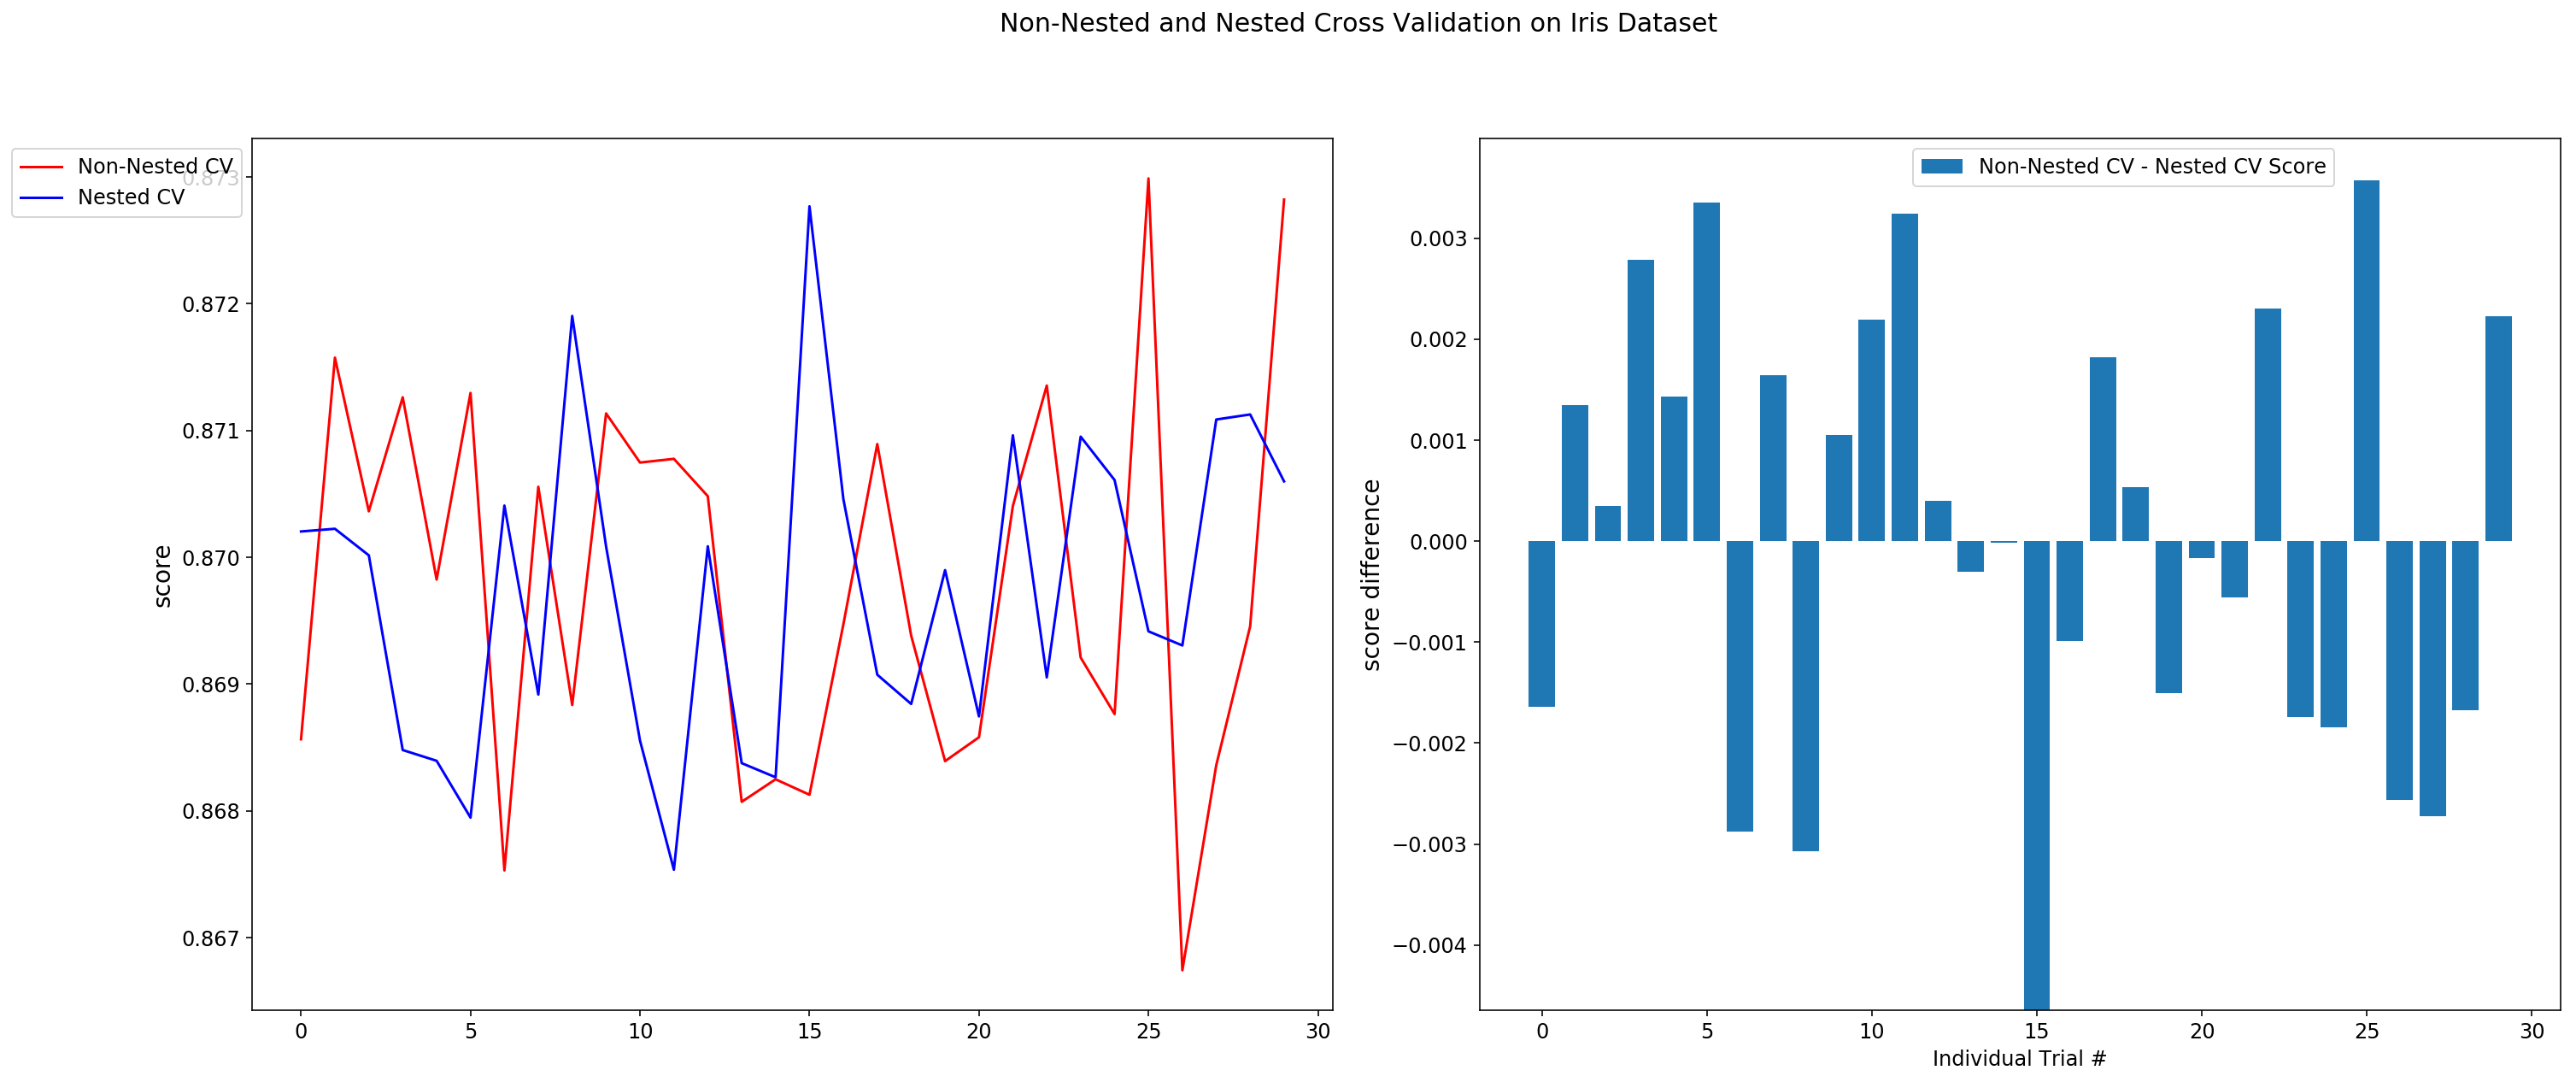

In [26]:
mp.plot_nested_cv(non_nested_acc, nested_acc)

In [27]:
nested_acc = joblib.load('../src/nested_scores_my_brier_scorer.pkl')
non_nested_acc = joblib.load('../src/non_nested_scores_my_brier_scorer.pkl')

Average difference of 0.000830 with std. dev. of 0.001466.


<module 'matplotlib.pyplot' from '/home/shurberto/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

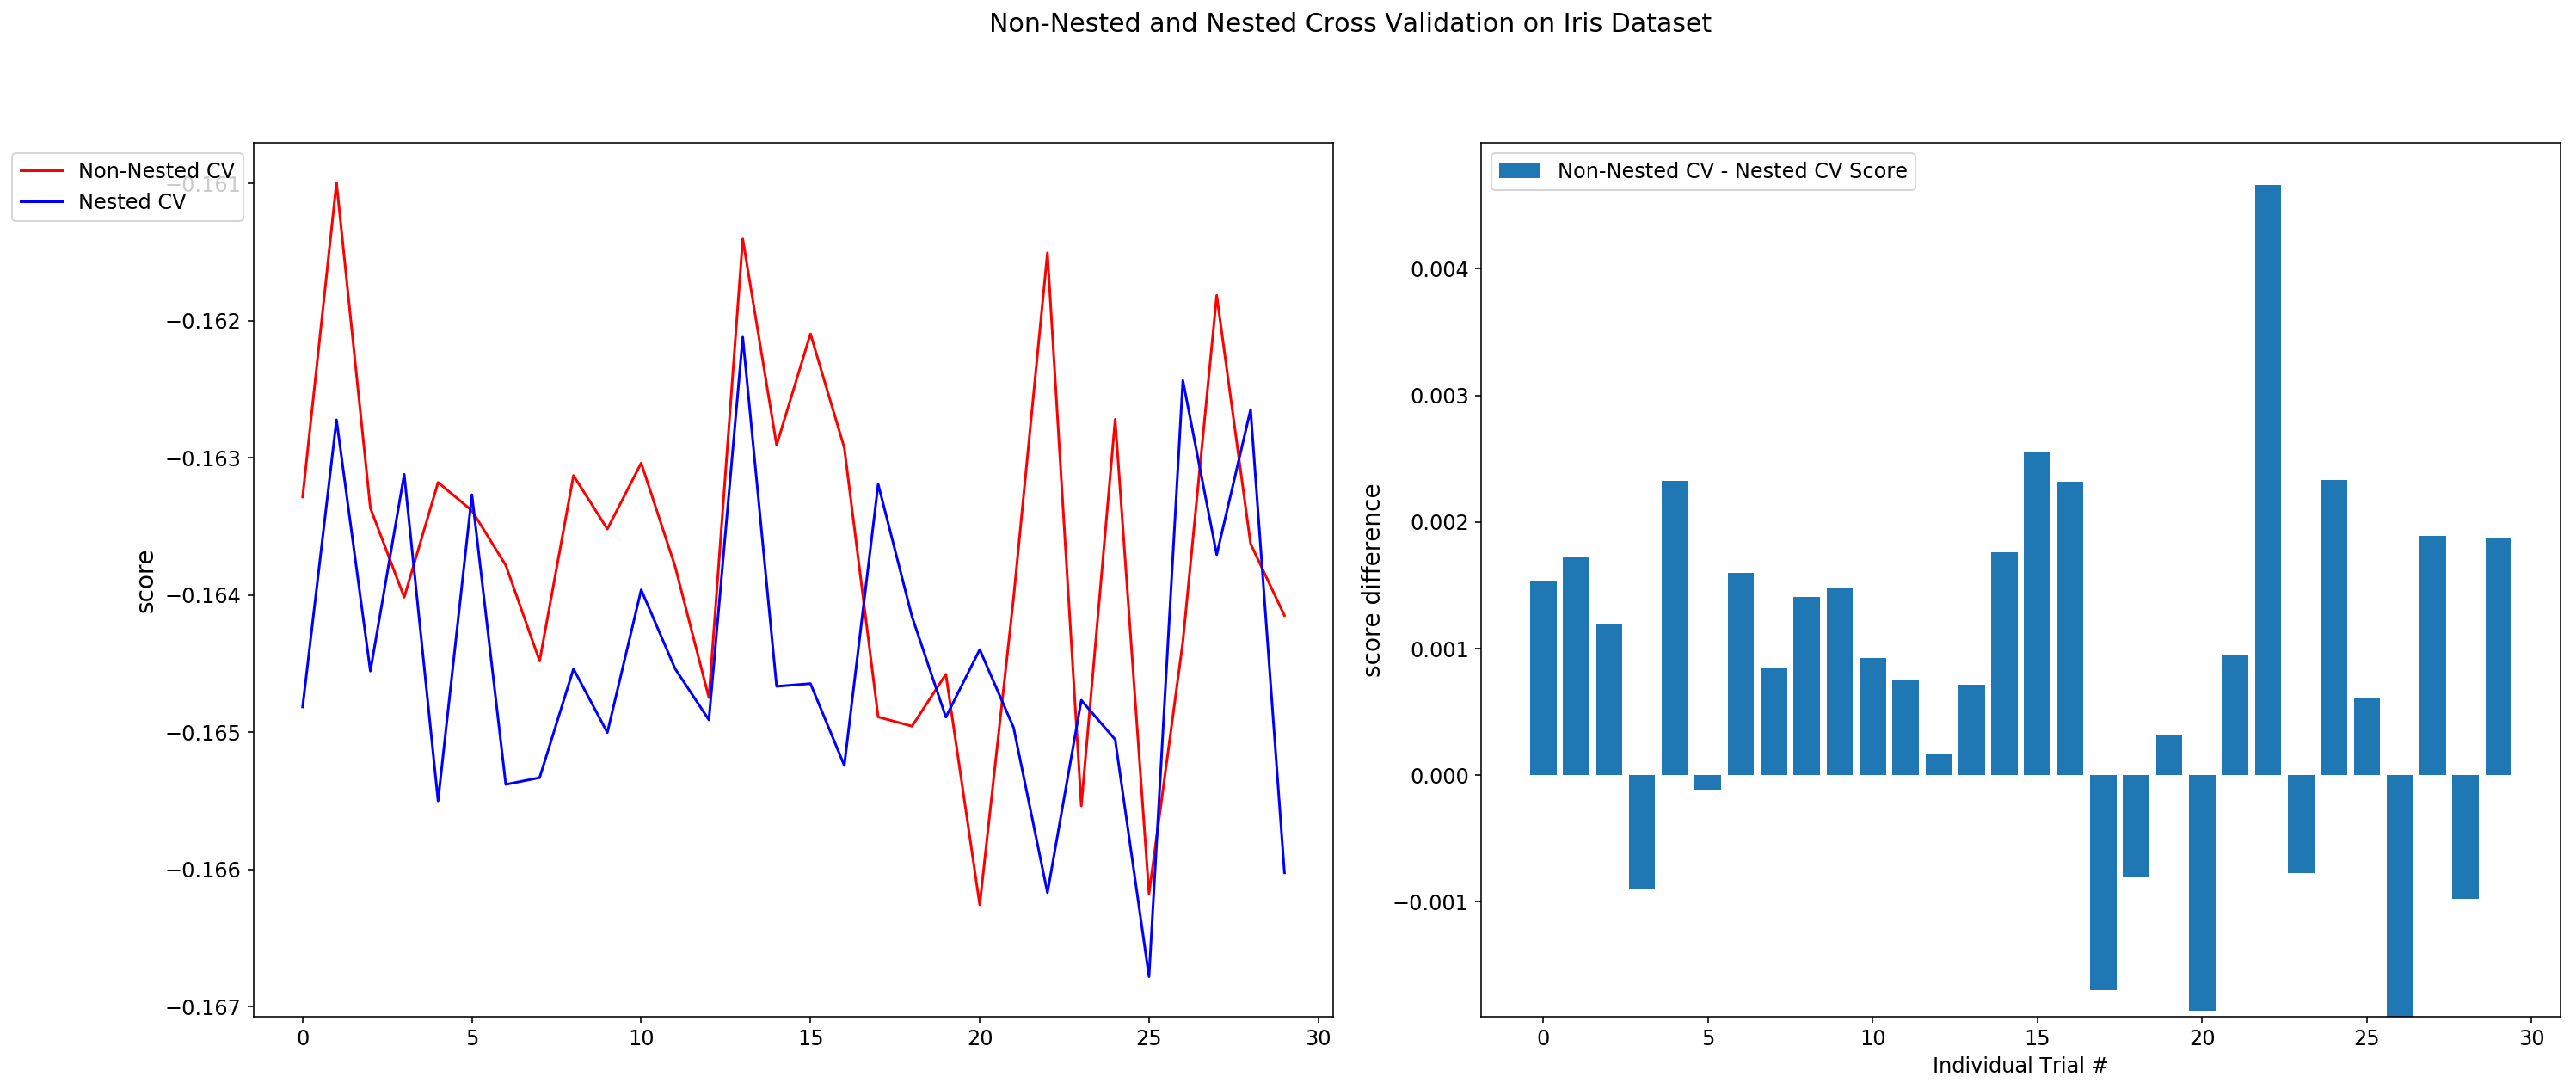

In [28]:
mp.plot_nested_cv(non_nested_acc, nested_acc)

In [33]:
del nested_clf
del non_nested_clf

In [36]:
clf1 = RandomForestClassifier(n_estimators=20, max_features=10, max_depth=12, bootstrap=False, criterion='entropy')
clf2 = RandomForestClassifier(n_estimators=20, max_features=10, max_depth=12, bootstrap=True, criterion='gini')
clf3 = RandomForestClassifier(n_estimators=20, max_features=10, max_depth=12, bootstrap=True, criterion='entropy')
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=1)

In [38]:
print('ACCURACY')
print('F-en --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())
print('T-gi --> %.4f' % cross_val_score(clf2, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())
print('T-en --> %.4f' % cross_val_score(clf3, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())

ACCURACY
F-en --> 0.8802
T-gi --> 0.8654
T-en --> 0.8692


In [39]:
print('BRIER')
print('F-en --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_brier_scorer).mean())
print('T-gi --> %.4f' % cross_val_score(clf2, cv=cv, X=X, y=Y, scoring=my_brier_scorer).mean())
print('T-en --> %.4f' % cross_val_score(clf3, cv=cv, X=X, y=Y, scoring=my_brier_scorer).mean())

BRIER
F-en --> -0.1588
T-gi --> -0.1578
T-en --> -0.1578


In [42]:
clf1.fit(X,Y)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=12, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
my_dict = dict(zip(clf1.feature_importances_, IN_OPTIONS))
NEW_IN = []
for elem in np.sort(clf1.feature_importances_)[::-1]:
    print('%-12s --> %s' % (my_dict.get(elem), elem))
    if elem > 0.02:
        NEW_IN.append(my_dict.get(elem))

IN_CS        --> 0.139191123446
IN_CR        --> 0.132560158361
IN_DS        --> 0.0925512547419
LZ4_CRate    --> 0.0752541285014
Sd           --> 0.0740848988929
BLZ_CRate    --> 0.0653336041903
LZ4_CSpeed   --> 0.0449280526303
LZ4_DSpeed   --> 0.0444039934128
Mean         --> 0.0423119973099
Max          --> 0.0392300081534
BLZ_CSpeed   --> 0.0374029057701
Kurt         --> 0.0336062867998
BLZ_DSpeed   --> 0.03052522087
Skew         --> 0.030071439432
Q3           --> 0.0251233940159
Min          --> 0.0189457050709
is_Int       --> 0.0172216230826
Q1           --> 0.0118064469007
is_Float     --> 0.0115259357877
Chunk_Size   --> 0.0113489564057
Median       --> 0.0105388338276
Type_Size    --> 0.00433591713108
is_String    --> 0.00383817434263
is_Table     --> 0.00273021355054
is_Columnar  --> 0.00112972737263


In [74]:
X = df[NEW_IN].values

In [75]:
clf1.fit(X,Y)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=12, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
clf1 = RandomForestClassifier(n_estimators=20, max_features=4, max_depth=12, bootstrap=False, criterion='entropy')
print('F-en --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())

F-en --> 0.8747


In [81]:
CUSTOM_IN = ['IN_CS', 'IN_DS', 'IN_CR', 'LZ4_CRate', 'Sd', 'LZ4_DSpeed', 'LZ4_CSpeed', 'Mean', 'Max']

In [82]:
X = df[CUSTOM_IN].values

In [83]:
print('F-en --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())

F-en --> 0.8739


In [84]:
clf1.fit(X, Y)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=12, max_features=4,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
my_dict = dict(zip(clf1.feature_importances_, CUSTOM_IN))
NEW_IN = []
for elem in np.sort(clf1.feature_importances_)[::-1]:
    print('%-12s --> %s' % (my_dict.get(elem), elem))

LZ4_CRate    --> 0.162866488191
Sd           --> 0.136835201142
IN_CS        --> 0.127101538725
IN_CR        --> 0.124018436699
LZ4_CSpeed   --> 0.0984244676361
LZ4_DSpeed   --> 0.096174975009
IN_DS        --> 0.0928905271466
Mean         --> 0.0885291203354
Max          --> 0.0731592451174


In [91]:
CUSTOM_IN = ['IN_CS', 'IN_DS', 'IN_CR', 'BLZ_CRate', 'Sd', 'Q3', 'BLZ_CSpeed', 'Mean', 'Max']

In [92]:
X = df[CUSTOM_IN].values

In [96]:
print('Acc --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_accuracy_scorer).mean())
print('Brier --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y, scoring=my_brier_scorer).mean())
print('N --> %.4f' % cross_val_score(clf1, cv=cv, X=X, y=Y).mean())

Acc --> 0.8764
Brier --> -0.1711
N --> 0.2861


In [94]:
clf1.fit(X, Y)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=12, max_features=4,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
my_dict = dict(zip(clf1.feature_importances_, CUSTOM_IN))
NEW_IN = []
for elem in np.sort(clf1.feature_importances_)[::-1]:
    print('%-12s --> %s' % (my_dict.get(elem), elem))

BLZ_CRate    --> 0.163933099005
IN_CR        --> 0.135217221084
Sd           --> 0.13052802704
IN_CS        --> 0.130159440043
BLZ_CSpeed   --> 0.122880245118
Mean         --> 0.0956029401823
IN_DS        --> 0.0855325404719
Max          --> 0.0777395376666
Q3           --> 0.0584069493898
